In [ ]:
import kagglehub
vbookshelf_respiratory_sound_database_path = kagglehub.dataset_download('vbookshelf/respiratory-sound-database')

print('Data source import complete.')


100%|██████████| 3.69G/3.69G [02:47<00:00, 23.7MB/s]

Extracting files...


Data source import complete.


In [ ]:
import wave
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
from os import listdir
from os.path import isfile, join
import librosa
import librosa.display
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D,BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
%matplotlib inline

In [ ]:
import os
os.listdir('/root/.cache/kagglehub/datasets/vbookshelf/respiratory-sound-database/versions/2')

['Respiratory_Sound_Database',
 'respiratory_sound_database',
 'demographic_info.txt']

In [ ]:
df_no_diagnosis = pd.read_csv('/root/.cache/kagglehub/datasets/vbookshelf/respiratory-sound-database/versions/2/demographic_info.txt', names =
                 ['Patient number', 'Age', 'Sex' , 'Adult BMI (kg/m2)', 'Child Weight (kg)' , 'Child Height (cm)'], delimiter = ' ')

diagnosis = pd.read_csv('/root/.cache/kagglehub/datasets/vbookshelf/respiratory-sound-database/versions/2/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv', names = ['Patient number', 'Diagnosis'])

In [ ]:
diagnosis = pd.read_csv('/root/.cache/kagglehub/datasets/vbookshelf/respiratory-sound-database/versions/2/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv', names=['Patient number', 'Diagnosis'], header=None) # Added header=None
df = df_no_diagnosis.join(diagnosis.set_index('Patient number'), on='Patient number', how='left')
df['Diagnosis'].value_counts()

Diagnosis
COPD              64
Healthy           26
URTI              14
Bronchiectasis     7
Bronchiolitis      6
Pneumonia          6
LRTI               2
Asthma             1
Name: count, dtype: int64

In [ ]:
root = '/root/.cache/kagglehub/datasets/vbookshelf/respiratory-sound-database/versions/2/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/'
filenames = [s.split('.')[0] for s in os.listdir(path = root) if '.txt' in s]

In [ ]:
def Extract_Annotation_Data(file_name, root):
    tokens = file_name.split('_')
    recording_info = pd.DataFrame(data = [tokens], columns = ['Patient number', 'Recording index', 'Chest location','Acquisition mode','Recording equipment'])
    recording_annotations = pd.read_csv(os.path.join(root, file_name + '.txt'), names = ['Start', 'End', 'Crackles', 'Wheezes'], delimiter= '\t')
    return (recording_info, recording_annotations)

In [ ]:
i_list = []
rec_annotations = []
rec_annotations_dict = {}
for s in filenames:
    (i,a) = Extract_Annotation_Data(s, root)
    i_list.append(i)
    rec_annotations.append(a)
    rec_annotations_dict[s] = a
recording_info = pd.concat(i_list, axis = 0)
recording_info.tail()

Patient number Recording index Chest location Acquisition mode  \
0            109             1b1             Ll               sc   
0            172             1b5             Al               mc   
0            198             1b5             Tc               mc   
0            158             1p4             Pl               mc   
0            107             2b5             Al               mc   

  Recording equipment  
0            Litt3200  
0            AKGC417L  
0            AKGC417L  
0            AKGC417L  
0            AKGC417L

In [ ]:
no_label_list = []
crack_list = []
wheeze_list = []
both_sym_list = []
filename_list = []
for f in filenames:
    d = rec_annotations_dict[f]
    no_labels = len(d[(d['Crackles'] == 0) & (d['Wheezes'] == 0)].index)
    n_crackles = len(d[(d['Crackles'] == 1) & (d['Wheezes'] == 0)].index)
    n_wheezes = len(d[(d['Crackles'] == 0) & (d['Wheezes'] == 1)].index)
    both_sym = len(d[(d['Crackles'] == 1) & (d['Wheezes'] == 1)].index)
    no_label_list.append(no_labels)
    crack_list.append(n_crackles)
    wheeze_list.append(n_wheezes)
    both_sym_list.append(both_sym)
    filename_list.append(f)

In [ ]:
file_label_df = pd.DataFrame(data = {'filename':filename_list})
file_label_df

filename
0    205_4b2_Ar_mc_AKGC417L
1    151_2p3_Al_mc_AKGC417L
2    172_1b4_Lr_mc_AKGC417L
3    208_1b1_Ll_sc_Meditron
4    104_1b1_Lr_sc_Litt3200
..                      ...
915  109_1b1_Ll_sc_Litt3200
916  172_1b5_Al_mc_AKGC417L
917  198_1b5_Tc_mc_AKGC417L
918  158_1p4_Pl_mc_AKGC417L
919  107_2b5_Al_mc_AKGC417L

[920 rows x 1 columns]

In [ ]:
audio_path = '/root/.cache/kagglehub/datasets/vbookshelf/respiratory-sound-database/versions/2/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/'

In [ ]:
# adding columns in file_label_df
diagnosis = []
patient_number = []
recording_index = []
chest_location = []
acquisition_mode = []
recording_equipment = []
sample_rate = []
duration = []

for i in tqdm(range(len(file_label_df['filename']))):
  info = file_label_df['filename'][i].split('_')
  patient_id, recording_idx, chest_loc, acq_mode, equipment = info
  #sound_filename = audio_path + file_label_df['filename'][i] + '.wav'
  #x, sr = librosa.load(sound_filename)
  #dur = round(x.shape[0]/sr, 2)
  #sample_rate.append(sr)
  #duration.append(dur)

  diagnosis.append(df['Diagnosis'][int(patient_id) - 101])
  patient_number.append(patient_id)
  recording_index.append(recording_idx)
  chest_location.append(chest_loc)
  acquisition_mode.append(acq_mode)
  recording_equipment.append(equipment)

file_label_df['Diagnosis'] = diagnosis
file_label_df['Patient Number'] = patient_number
file_label_df['Chest Location'] = chest_location
file_label_df['Acquisition Mode'] = acquisition_mode
file_label_df['Recording Equipment'] = recording_equipment
#file_label_df['duration'] = duration
#file_label_df['sample rate'] = sample_rate

  0%|          | 0/920 [00:00<?, ?it/s]

In [ ]:
file_label_df

filename Diagnosis Patient Number Chest Location  \
0    205_4b2_Ar_mc_AKGC417L      COPD            205             Ar   
1    151_2p3_Al_mc_AKGC417L      COPD            151             Al   
2    172_1b4_Lr_mc_AKGC417L      COPD            172             Lr   
3    208_1b1_Ll_sc_Meditron   Healthy            208             Ll   
4    104_1b1_Lr_sc_Litt3200      COPD            104             Lr   
..                      ...       ...            ...            ...   
915  109_1b1_Ll_sc_Litt3200      COPD            109             Ll   
916  172_1b5_Al_mc_AKGC417L      COPD            172             Al   
917  198_1b5_Tc_mc_AKGC417L      COPD            198             Tc   
918  158_1p4_Pl_mc_AKGC417L      COPD            158             Pl   
919  107_2b5_Al_mc_AKGC417L      COPD            107             Al   

    Acquisition Mode Recording Equipment  
0                 mc            AKGC417L  
1                 mc            AKGC417L  
2                 mc            AKGC417L  
3                 sc            Meditron  
4                 sc            Litt3200  
..               ...                 ...  
915               sc            Litt3200  
916               mc            AKGC417L  
917               mc            AKGC417L  
918               mc            AKGC417L  
919               mc            AKGC417L  

[920 rows x 6 columns]

In [ ]:
diagnosis_3 = []
for i in range(len(file_label_df['Diagnosis'])):
  diagnosis = file_label_df['Diagnosis'][i]
  if diagnosis == 'COPD' or diagnosis == 'Bronchiectasis' or diagnosis == 'Asthma':
    diagnosis_3.append('Chronic Disease')
  elif diagnosis == 'URTI' or diagnosis == 'LRTI' or diagnosis == 'Pneumonia' or diagnosis == 'Bronchiolitis':
    diagnosis_3.append('Non-Chronic Disease')
  else:
    diagnosis_3.append('normal')

file_label_df['3 label diagnosis'] = diagnosis_3

In [ ]:
file_label_df['Diagnosis'].value_counts()

Diagnosis
COPD              793
Pneumonia          37
Healthy            35
URTI               23
Bronchiectasis     16
Bronchiolitis      13
LRTI                2
Asthma              1
Name: count, dtype: int64

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
import numpy as np
import glob
import soundfile
from scipy.io.wavfile import read

In [ ]:
i = 100
sound_filename = audio_path + file_label_df['filename'][i] + '.wav'

In [ ]:
import IPython.display as ipd
ipd.Audio(sound_filename, rate=16000)

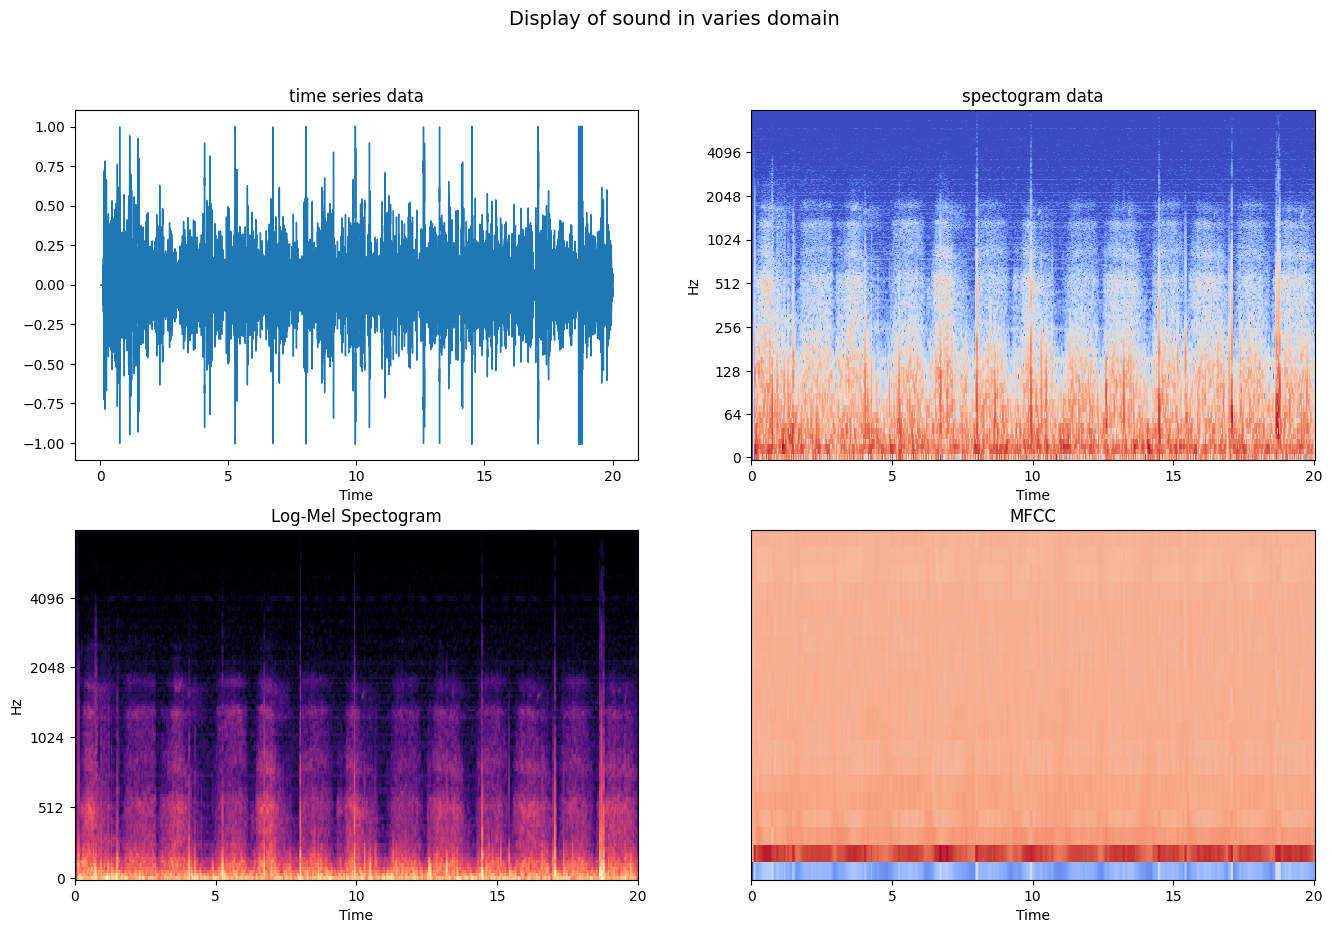

In [ ]:
# Displaying sound data
"""
  time series : amplitude of sound is varied in time domain (1D)
  spectogram : amplitude of sound is varied in time and frequency domain (2D)
"""
# time series data
sr_new = 16000 # resample 16 kHz
x, sr = librosa.load(sound_filename, sr=sr_new) # x : time series data, sr : sample rate

# Spectogram data
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))

# Log-mel spectogram
mel = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=128, fmax=8000)
log_mel = librosa.power_to_db(mel, ref=np.max)


# Mel-Frequency Cepstral Coefficient (MFCC)
mfccs = librosa.feature.mfcc(y=x, sr=sr)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))

librosa.display.waveshow(y=x, sr=sr, ax=ax[0, 0])
ax[0, 0].set(title='time series data')

librosa.display.specshow(Xdb, x_axis='time',
                         y_axis='log', sr=sr, ax=ax[0, 1])
ax[0, 1].set(title='spectogram data')

librosa.display.specshow(log_mel, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax[1, 0])
ax[1, 0].set(title='Log-Mel Spectogram')


librosa.display.specshow(mfccs, sr=sr, x_axis='time', ax=ax[1, 1])
ax[1, 1].set(title='MFCC')

plt.suptitle("Display of sound in varies domain", fontsize=14);

In [ ]:
def preprocessing(audio_file, mode):
    # we want to resample audio to 16 kHz
    sr_new = 16000 # 16kHz sample rate
    x, sr = librosa.load(audio_file, sr=sr_new)

    # padding sound
    # because duration of sound is dominantly 20 s and all of sample rate is 22050
    # we want to pad or truncated sound which is below or above 20 s respectively
    max_len = 5 * sr_new  # length of sound array = time x sample rate
    if x.shape[0] < max_len:
      # padding with zero
      pad_width = max_len - x.shape[0]
      x = np.pad(x, (0, pad_width))
    elif x.shape[0] > max_len:
      # truncated
      x = x[:max_len]

    if mode == 'mfcc':
      feature = librosa.feature.mfcc(y=x, sr=sr_new)

    elif mode == 'log_mel':
      feature = librosa.feature.melspectrogram(y=x, sr=sr_new, n_mels=128, fmax=8000)
      feature = librosa.power_to_db(feature, ref=np.max)


    return feature

In [ ]:
# apply preprocessing to sound data

labels = []
labels_3 = []
preprocessed_data = []
for i in tqdm(range(len(file_label_df['filename']))):
  labels.append(file_label_df['Diagnosis'][i])
  #labels_3.append(file_label_df['3 label diagnosis'][i])
  audio_file = audio_path + file_label_df['filename'][i] + '.wav'
  data = preprocessing(audio_file, mode = 'mfcc')
  preprocessed_data.append(data)
preprocessed_data = np.array(preprocessed_data)
labels = np.array(labels)
labels_3 = np.array(labels_3)

  0%|          | 0/920 [00:00<?, ?it/s]

In [ ]:
preprocessed_data[0].shape

(20, 157)

In [ ]:
preprocessed_data = preprocessed_data.reshape((-1, 20, 157, 1))

In [ ]:
# one hot encoding labels
encoder = LabelEncoder()
i_labels = encoder.fit_transform(labels)
oh_labels = to_categorical(i_labels,num_classes=8)

#encoder_3 = LabelEncoder()
#i_labels_3 = encoder_3.fit_transform(labels_3)
#oh_labels_3 = to_categorical(i_labels_3)

In [ ]:
oh_labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
type(oh_labels)

numpy.ndarray

In [ ]:
print(list(encoder.classes_))

[np.str_('Asthma'), np.str_('Bronchiectasis'), np.str_('Bronchiolitis'), np.str_('COPD'), np.str_('Healthy'), np.str_('LRTI'), np.str_('Pneumonia'), np.str_('URTI')]


In [ ]:
unique_values, counts = np.unique(oh_labels, return_counts=True)

# Display unique values and their counts
for value, count in zip(unique_values, counts):
    print(f"Value: {value}, Count: {count}")

Value: 0.0, Count: 6440
Value: 1.0, Count: 920


In [ ]:
# train test split
x_train, x_test, y_train, y_test = train_test_split(preprocessed_data, oh_labels,
                                                    test_size=0.2, random_state = 42)

In [ ]:
print("size of training set= ",len(x_train))
print("size of testing set= ",len(x_test))

size of training set=  736
size of testing set=  184


In [ ]:
oh_labels.shape

(920, 8)

In [ ]:

num_rows = 20
num_columns = 157
num_channels = 1


num_labels = oh_labels.shape[1]
filter_size = 2

# Construct model
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=filter_size,
                 input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))

model.add(Conv2D(filters=32, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))

model.add(Conv2D(filters=64, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))


model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax'))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 19, 156, 16)    │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 9, 78, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 9, 78, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 9, 78, 64)      │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 77, 32)      │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 38, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4, 38, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4, 38, 64)      │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 37, 64)      │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 18, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 18, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,472 (111.22 KB)

 Trainable params: 28,472 (111.22 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [ ]:
y_train[1].shape

(8,)

In [ ]:
# train model
num_epochs = 300
num_batch_size = 64

callbacks = [
    ModelCheckpoint(
        filepath='mymodel2_{epoch:02d}.keras',
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_accuracy` score has improved.
        save_best_only=True,
        monitor='val_accuracy',
        verbose=1)
]
start = datetime.now()

history = model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs,
          validation_split=0.1, callbacks=callbacks, verbose=1)



duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.2084 - loss: 22.5274
Epoch 1: val_accuracy improved from -inf to 0.82432, saving model to mymodel2_01.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 14s 662ms/step - accuracy: 0.2307 - loss: 21.6054 - val_accuracy: 0.8243 - val_loss: 2.2556
Epoch 2/300
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8654 - loss: 2.5387 
Epoch 2: val_accuracy did not improve from 0.82432
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8661 - loss: 2.4311 - val_accuracy: 0.8243 - val_loss: 1.2956
Epoch 3/300
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8780 - loss: 1.1144 
Epoch 3: val_accuracy did not improve from 0.82432
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8730 - loss: 1.1100 - val_accuracy: 0.8243 - val_loss: 1.1821
Epoch 4/300
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8775 - loss: 0.8281 
Epoch 4: val_accuracy did not improve from 0.82432
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8750 - lo

<Figure size 640x480 with 0 Axes>

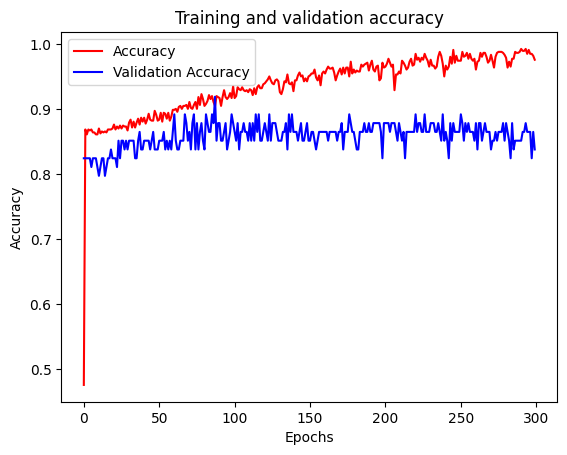

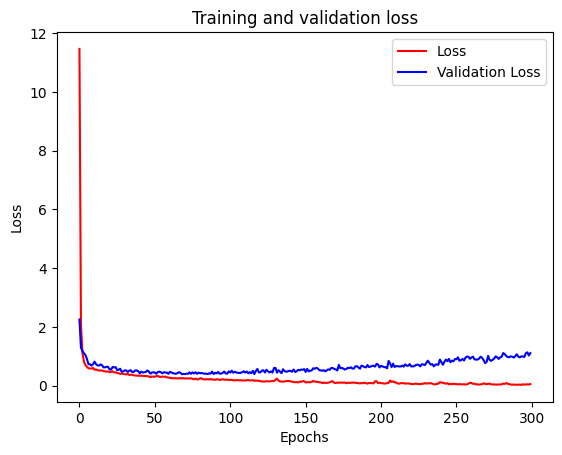

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


# Expected Output
# A chart where the validation loss does not increase sharply!

In [ ]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9714673757553101
Testing Accuracy:  0.907608687877655


In [ ]:
preds = model.predict(x_test) # label scores

classpreds = np.argmax(preds, axis=1) # predicted classes

y_testclass = np.argmax(y_test, axis=1) # true classes

n_classes=8 # number of classes

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step


In [ ]:
encoder.classes_

array(['Asthma', 'Bronchiectasis', 'Bronchiolitis', 'COPD', 'Healthy',
       'LRTI', 'Pneumonia', 'URTI'], dtype='<U14')

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

c_names = ['Asthma', 'Bronchiectasis', 'Bronchiolitis', 'COPD', 'Healthy',
       'LRTI', 'Pneumonia', 'URTI']

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


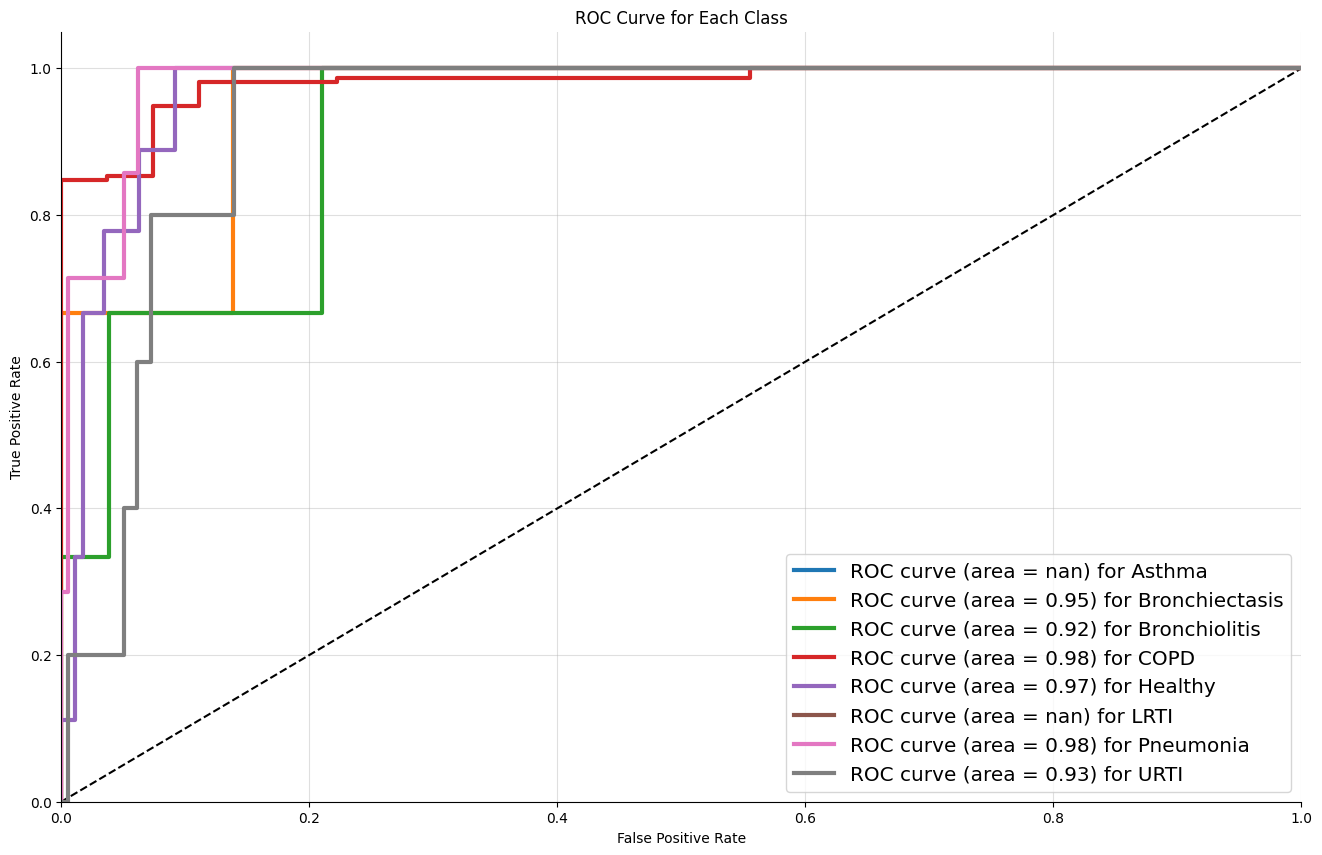

In [ ]:
# Plot ROC curves
fig, ax = plt.subplots(figsize=(16, 10))
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve for Each Class')
for i in range(n_classes):
    ax.plot(fpr[i], tpr[i], linewidth=3, label='ROC curve (area = %0.2f) for %s' % (roc_auc[i], c_names[i]))
ax.legend(loc="best", fontsize='x-large')
ax.grid(alpha=.4)
sns.despine()
plt.show()

In [ ]:
c_names

['Asthma',
 'Bronchiectasis',
 'Bronchiolitis',
 'COPD',
 'Healthy',
 'LRTI',
 'Pneumonia',
 'URTI']

In [ ]:
print(confusion_matrix(y_testclass, classpreds))

[[  2   0   1   0   0   0   0]
 [  0   1   1   0   0   0   1]
 [  0   0 154   2   0   1   0]
 [  0   2   1   6   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   2   2   0   3   0]
 [  0   0   1   1   2   0   1]]


In [ ]:
preprocessed_data.shape

(920, 20, 157, 1)

In [ ]:
from imblearn.over_sampling import RandomOverSampler
import numpy as np



n_samples, height, width, channels = preprocessed_data.shape
X_reshaped = preprocessed_data.reshape(n_samples, -1)

# Instantiate RandomOverSampler
random_oversampler = RandomOverSampler()

# Upsample the minority class using RandomOverSampler
X_resampled, y_resampled = random_oversampler.fit_resample(X_reshaped, oh_labels)
X_restored = X_resampled.reshape(-1, 20, 157, 1)


# Check the shape of the resampled data
print("Shape of X_resampled:", X_resampled.shape)
print("Shape of y_resampled:", y_resampled.shape)

Shape of X_resampled: (6344, 3140)
Shape of y_resampled: (6344, 8)


In [ ]:
X_restored.shape

(6344, 20, 157, 1)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X_restored, y_resampled, stratify=y_resampled,
                                                    test_size=0.2, random_state = 42)

In [ ]:
print("size of training set= ",len(x_train))
print("size of testing set= ",len(x_test))

size of training set=  5075
size of testing set=  1269


In [ ]:
num_rows = 20
num_columns = 157
num_channels = 1


num_labels = oh_labels.shape[1]
filter_size = 2

# Construct model
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=filter_size,
                 input_shape=(num_rows, num_columns,num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))

model.add(Conv2D(filters=32, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))

model.add(Conv2D(filters=64, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))


model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax'))

model.summary()

# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# train model
num_epochs = 300
num_batch_size = 64

callbacks = [
    ModelCheckpoint(
        filepath='mymodel3_{epoch:02d}.keras',
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_accuracy` score has improved.
        save_best_only=True,
        monitor='val_accuracy',
        verbose=1)
]
start = datetime.now()

history = model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs,
          validation_split=0.1, callbacks=callbacks, verbose=1)



duration = datetime.now() - start
print("Training completed in time: ", duration)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 19, 156, 16)    │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 78, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 9, 78, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9, 78, 64)      │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 77, 32)      │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 38, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 4, 38, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4, 38, 64)      │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 3, 37, 64)      │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 1, 18, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1, 18, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,472 (111.22 KB)

 Trainable params: 28,472 (111.22 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/300
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.1471 - loss: 7.6977
Epoch 1: val_accuracy improved from -inf to 0.20079, saving model to mymodel3_01.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 13s 107ms/step - accuracy: 0.1477 - loss: 7.6463 - val_accuracy: 0.2008 - val_loss: 2.0767
Epoch 2/300
67/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3135 - loss: 1.8077
Epoch 2: val_accuracy improved from 0.20079 to 0.34843, saving model to mymodel3_02.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3157 - loss: 1.8013 - val_accuracy: 0.3484 - val_loss: 1.7514
Epoch 3/300
71/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4687 - loss: 1.4876
Epoch 3: val_accuracy improved from 0.34843 to 0.54528, saving model to mymodel3_03.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4689 - loss: 1.4865 - val_accuracy: 0.5453 - val_loss: 1.5216
Epoch 4/300
70/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5334 - loss: 1.3616
Epoch 4: val_accuracy did not improve from 0

<Figure size 640x480 with 0 Axes>

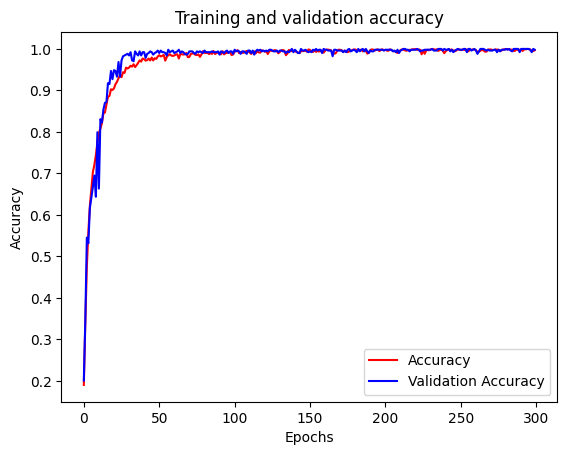

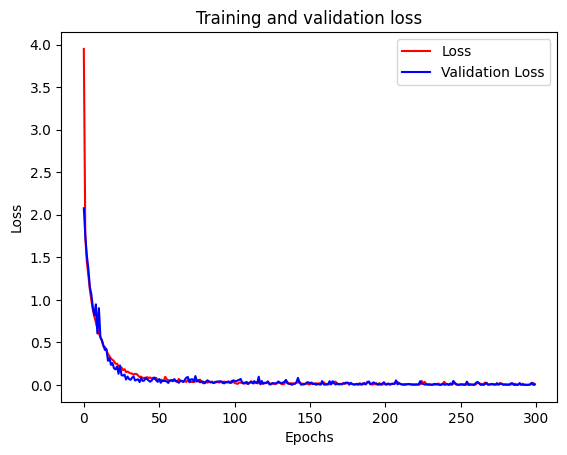

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


# Expected Output
# A chart where the validation loss does not increase sharply!

In [ ]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9998029470443726
Testing Accuracy:  0.9960598945617676


In [ ]:
preds = model.predict(x_test) # label scores

classpreds = np.argmax(preds, axis=1) # predicted classes

y_testclass = np.argmax(y_test, axis=1) # true classes

n_classes=8 # number of classes

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


In [ ]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


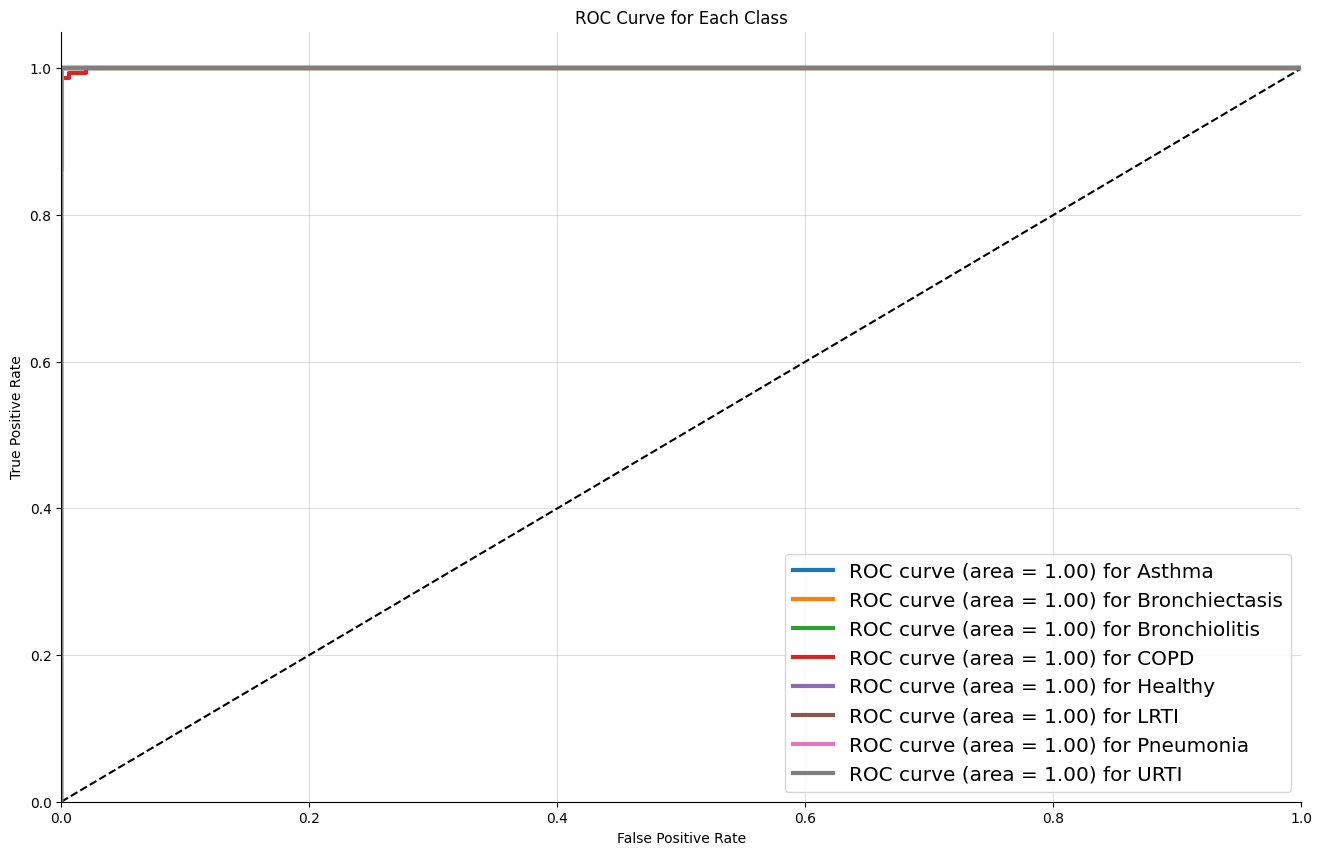

In [ ]:
# Plot ROC curves
fig, ax = plt.subplots(figsize=(16, 10))
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve for Each Class')
for i in range(n_classes):
    ax.plot(fpr[i], tpr[i], linewidth=3, label='ROC curve (area = %0.2f) for %s' % (roc_auc[i], c_names[i]))
ax.legend(loc="best", fontsize='x-large')
ax.grid(alpha=.4)
sns.despine()
plt.show()

In [ ]:
# Classification Report
print(classification_report(y_testclass, classpreds, target_names=c_names))

                precision    recall  f1-score   support

        Asthma       1.00      1.00      1.00       159
Bronchiectasis       0.99      1.00      1.00       159
 Bronchiolitis       1.00      1.00      1.00       158
          COPD       1.00      0.97      0.98       159
       Healthy       1.00      1.00      1.00       159
          LRTI       1.00      1.00      1.00       159
     Pneumonia       0.98      1.00      0.99       158
          URTI       1.00      1.00      1.00       158

      accuracy                           1.00      1269
     macro avg       1.00      1.00      1.00      1269
  weighted avg       1.00      1.00      1.00      1269



In [ ]:
# Confusion Matrix
print(confusion_matrix(y_testclass, classpreds))

[[159   0   0   0   0   0   0   0]
 [  0 159   0   0   0   0   0   0]
 [  0   0 158   0   0   0   0   0]
 [  0   1   0 154   0   0   4   0]
 [  0   0   0   0 159   0   0   0]
 [  0   0   0   0   0 159   0   0]
 [  0   0   0   0   0   0 158   0]
 [  0   0   0   0   0   0   0 158]]


In [ ]:
export_dir = 'saved_model/my_model'

tf.saved_model.save(model, export_dir=export_dir)

In [ ]:
model.save('prediction_lung_disease_model.keras')

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Conv2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report
import numpy as np
from datetime import datetime

# Resize inputs to MobileNetV2 requirements
IMG_SIZE = 128  # (Minimum: 96x96)
NUM_CLASSES = oh_labels.shape[1]

# Convert to RGB-like shape (expand grayscale -> 3 channels)
x_train_rgb = tf.image.resize(x_train, (IMG_SIZE, IMG_SIZE))
x_test_rgb = tf.image.resize(x_test, (IMG_SIZE, IMG_SIZE))
x_train_rgb = tf.repeat(x_train_rgb, 3, axis=-1)  # (batch, 128, 128, 3)
x_test_rgb = tf.repeat(x_test_rgb, 3, axis=-1)

# Define MobileNetV2 model
base_model = MobileNetV2(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), weights='imagenet')
base_model.trainable = False  # Freeze base

inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs, x)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

# Save best model
checkpoint_cb = ModelCheckpoint('mobilenetv2_csi_best.keras', save_best_only=True, monitor='val_accuracy', verbose=1)

# Train
start = datetime.now()

history = model.fit(x_train_rgb, y_train,
                    epochs=20,
                    batch_size=64,
                    validation_split=0.1,
                    callbacks=[checkpoint_cb],
                    verbose=1)

duration = datetime.now() - start
print("⏱️ Training completed in time:", duration)

# Evaluate
model.load_weights('mobilenetv2_csi_best.keras')
train_acc = model.evaluate(x_train_rgb, y_train, verbose=0)[1]
test_acc = model.evaluate(x_test_rgb, y_test, verbose=0)[1]

print(f"\n✅ Train Accuracy: {train_acc:.4f}")
print(f"✅ Test Accuracy:  {test_acc:.4f}")

# Classification report
y_pred = model.predict(x_test_rgb)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

print("\n📊 Classification Report:")
print(classification_report(y_true_labels, y_pred_labels))


Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,984 (9.24 MB)

 Trainable params: 165,000 (644.53 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.6430 - loss: 1.0822
Epoch 1: val_accuracy improved from -inf to 0.96654, saving model to mobilenetv2_csi_best.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 18s 155ms/step - accuracy: 0.6453 - loss: 1.0761 - val_accuracy: 0.9665 - val_loss: 0.2446
Epoch 2/20
71/72 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9720 - loss: 0.1749
Epoch 2: val_accuracy improved from 0.96654 to 0.98622, saving model to mobilenetv2_csi_best.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.9721 - loss: 0.1740 - val_accuracy: 0.9862 - val_loss: 0.1038
Epoch 3/20
69/72 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9879 - loss: 0.0832
Epoch 3: val_accuracy improved from 0.98622 to 0.99016, saving model to mobilenetv2_csi_best.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9881 - loss: 0.0822 - val_accuracy: 0.9902 - val_loss: 0.0585
Epoch 4/20
70/72 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9952 - loss: 0.0436
Epoch 4: val_ac

In [ ]:


import librosa
import numpy as np
import tensorflow as tf

# Load the trained model (replace with your actual model path)
model = tf.keras.models.load_model('/content/prediction_lung_disease_model.keras')

def predict_lung_disease(wav_file_path):
    """
    Predicts lung disease from a WAV audio file.

    Args:
        wav_file_path: Path to the WAV file.

    Returns:
        A string representing the predicted lung disease.
    """
    try:
        # Preprocessing (same as in your training script)
        sr_new = 16000
        x, sr = librosa.load(wav_file_path, sr=sr_new)
        max_len = 5 * sr_new
        if x.shape[0] < max_len:
            pad_width = max_len - x.shape[0]
            x = np.pad(x, (0, pad_width))
        elif x.shape[0] > max_len:
            x = x[:max_len]

        feature = librosa.feature.mfcc(y=x, sr=sr_new)
        feature = feature.reshape(1, 20, 157, 1)

        # Prediction
        prediction = model.predict(feature)
        predicted_class_index = np.argmax(prediction)

        # Class names (replace with your actual class names)
        class_names = ['Asthma', 'Bronchiectasis', 'Bronchiolitis', 'COPD', 'Healthy',
                       'LRTI', 'Pneumonia', 'URTI']
        predicted_class = class_names[predicted_class_index]

        return predicted_class

    except Exception as e:
        print(f"Error during prediction: {e}")
        return None




file1 = audio_path + file_label_df['filename'][150] + '.wav'

file2 = audio_path + file_label_df['filename'][100] + '.wav'

prediction1 = predict_lung_disease(file1)
prediction2 = predict_lung_disease(file2)

if prediction1:
    print(f"Prediction for {file1}: {prediction1}")
if prediction2:
    print(f"Prediction for {file2}: {prediction2}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Prediction for /root/.cache/kagglehub/datasets/vbookshelf/respiratory-sound-database/versions/2/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/135_2b1_Tc_mc_LittC2SE.wav: Pneumonia
Prediction for /root/.cache/kagglehub/datasets/vbookshelf/respiratory-sound-database/versions/2/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/176_2b3_Tc_mc_AKGC417L.wav: COPD
